# An Minimal Example for MCMCDebugging.jl

We start by defining a Beta-Binomial model, two posterior samplers (one bug-free and one buggy) and some functions to use.

In [1]:
using Distributions

# Beta-Binomial model
n = 3                            # num. of trials
dist_θ = Beta(2, 3)              # prior
dist_x_given(θ) = Binomial(n, θ) # likelihood

# True posterior
dist_θ_given(x) = Beta(dist_θ.α + x, dist_θ.β + n - x)

# Marginal-conditional simulator
rand_θ() = rand(dist_θ)
rand_x_given(θ) = rand(dist_x_given(θ))

# Successive-conditional simulators
# 1. Bug-free posterior sampler
rand_θ_given(x) = rand(dist_θ_given(x))
# 2. Buggy posterior sampler
rand_θ_given_buggy(x) = rand(dist_θ_given(min(n, x + 1)))

# Log-joint and test function
logjoint(θ, x) = logpdf(dist_θ, only(θ)) + logpdf(dist_x_given(only(θ)), only(x))
g(θ, x) = cat(θ, x; dims=1)

g (generic function with 1 method)

We firstly perform Geweke test for the bug-free sampler.

In [2]:
using MCMCDebugging

res = perform(GewekeTest(2_000), rand_θ, rand_x_given, rand_θ_given, g)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Geweke (Joint Distribution) Test
--------------------------------
Results:
    Number of samples: 2000
    Parameter dimension: 1
    Data dimension: 1
    Statistic: [-2.021486477284146, -2.2983073865350616]


We can also visualise the result via the Q-Q plot. Plotting functionality is supported via Plots.jl.

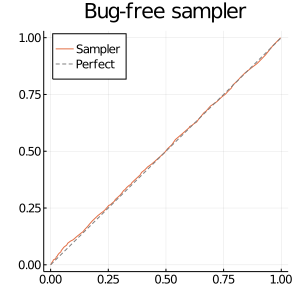

In [3]:
using Plots

plot(res, logjoint; size=(300, 300), title="Bug-free sampler")

Let's try Geweke test on the buggy sampler now.

In [4]:
res_buggy = perform(GewekeTest(2_000), rand_θ, rand_x_given, rand_θ_given_buggy)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Test function `g` is not provided. Statistic is not computed.
└ @ MCMCDebugging /afs/inf.ed.ac.uk/user/s16/s1672897/projects/ParallelHMC/src/MCMCDebugging.jl/src/geweke.jl:68


Geweke (Joint Distribution) Test
--------------------------------
Results:
    Number of samples: 2000
    Parameter dimension: 1
    Data dimension: 1
    Statistic: missing

Test statistic is missing. Please use `compute_statistic!(res, g)` 
if you want compute statistic without rerun the simulation.



Oops -- I also didn't passing the testing function `g`. Let's follow the recommendation to update the result.

In [5]:
compute_statistic!(res_buggy, g)

Geweke (Joint Distribution) Test
--------------------------------
Results:
    Number of samples: 2000
    Parameter dimension: 1
    Data dimension: 1
    Statistic: [-35.852631718041685, -22.25900938464689]


Notably, the visualization is very informative.

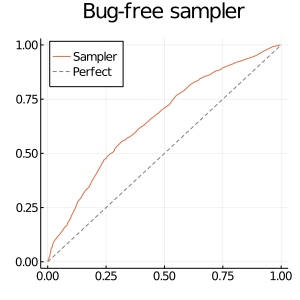

In [6]:
plot(res_buggy, logjoint; size=(300, 300), title="Bug-free sampler")

You can also check the maximum mean discrepancy (MMD) using the two results.

In [7]:
@info "MMD" mmd_of(res) mmd_of(res_buggy)

┌ Info: MMD
│   mmd_of(res) = 0.000860478896075767
│   mmd_of(res_buggy) = 0.0709781804150455
└ @ Main In[7]:1


As you can see, the bug-free one attains a much smaller value, meaning the marginal-conditional simulator and the bug-free successive-conditional simulator admit more similar distributions.